# Diversity in Milan neighborhoods
The Metropolitan City of Milan is the italian leader city in the industrial sector and the real economic power of Italy.
Famous for fashion and design, with more than one milion people it is one of the most populous cities and the second most visited city in Italy, second only to Rome.

In 2019 Milan confirmed itself as third most expesive city in Italy and today it is the most european city in Italy. This is for sure because of the public administration investments in neighborhoods transformation and international advertising related to events of all kinds. However, as you can imagine, not every neighborhood is equal.

People in Milan live their own life spending their times in multiple activities all around the city. We are going to classify every neighborhood based on what activies are preponderant in their area. We will compare their peculiarities to house prices and construction or restorations activities in order to provide a model for all the people who want to move in Milan or who want to better know the differences between Milan neighborhoods.

## Data sources
For this research we decided to start from the data provided by the data archive of Milan.
We obtained the NIL map of Milan (in Italy a NIL map is the local identity map area) representings areas we can identify as neighborhoods. This was introduced by the Milan PTG (plan of government of the territory) as a collection of scopes linked togheter by infrastructures and services. They are the 88 places of urban vitality we are interested in. This data is granular enought to let use begin our investigation. You can find the entire database here: https://dati.comune.milano.it/dataset/ds61_infogeo_nil_localizzazione_
Starting from this data we have aggregated many other sources:
1. List of practices presented for construction activities - we used this data to understand which area is undergoing major transformations (https://dati.comune.milano.it/dataset/ds676_pratiche_edilizie_online_sportello_unico_per_ledilizia)
2. List of bus stops - we used this data to understand infrastructures connections inside the city (https://dati.comune.milano.it/dataset/ds528_trasporto-pubblico-locale-entro-i-confini-comunali-2008-2013)
3. A List of venues and commercial activities we obtained from Foursquare API - we used this data to better understand social interactions inside every neighborhood
4. House prices and rents cost - we web-scraped this information from https://www.immobiliare.it/mercato-immobiliare/lombardia/milano/. We used this data as an indicator of perceived quality.

In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
from sklearn.cluster import KMeans
import folium
import requests
import geocoder
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

NEIGHBORHOOD_FILE = 'milan_data/quartieri.geojson';
BUSSTOPS_FILE = r'milan_data/fermate-superficie.geojson';
NEIGHBORHOOD_ITEMS_FILE = 'milan_data/quartieri-centroidi.json';
VENUES_FILE = 'milan_data/venues-info.csv';
DISTRICT_FILE = 'milan_data/ds632_street_sport_con_orari_v2_loc.csv'
NEIGHBORHOOD_ITEMS = []
PLACE = [45.464161, 9.190336]
FOURSQUARE_CLIENT_ID = '???' 
FOURSQUARE_CLIENT_SECRET = '???' 

> **A note about performance**
In this notebook I had to save the ouput of my queries into many files in order to have better performance when a reload was needed. I have commented the original source code so you can uncomment the code to perform the query by your own.

### Finding neighborhood centers
Despite some approximation I found useful asking `arcgis` che neighborhood name by itself in order to obtain latitude and longitude.

`Arcgis` failed some query, so I added manualy some points directly into the `.json` file I saved.
You can find the final output of `arcgis` query plus my manual integration into `milan_data/quartieri-centroidi.json`

In [2]:
'''
# Original Query
with open(neighborhood_FILE) as json_file:
    data = json.load(json_file)
    for p in data['features']:
        name = p['properties']['NIL']
        geocoderPosition = geocoder.arcgis(location = '{}, Milano, Italia'.format(name)).json
        if geocoderPosition['ok'] == True:
            item = { 'name': name, 'lat': geocoderPosition['lat'], 'lng': geocoderPosition['lng'] }
        else:
            item = { 'name': name, 'lat': None, 'lng': None }
        NEIGHBORHOOD_ITEMS.append(item)'''

# Cached Query + manual integrations
with open(NEIGHBORHOOD_ITEMS_FILE) as json_file:
    NEIGHBORHOOD_ITEMS = json.load(json_file)
neighborhood_df = pd.read_json(NEIGHBORHOOD_ITEMS_FILE)
neighborhood_df = neighborhood_df[['name', 'lat', 'lng']]
neighborhood_df.head()

name        lat       lng
0        SACCO  45.464600  9.152800
1     COMASINA  45.526400  9.159900
2   STEPHENSON  45.512744  9.114172
3         QT 8  45.486030  9.138410
4  ORTOMERCATO  45.465090  9.183900

Neighborhood differs for many reason. Area is one of them.

In [3]:
import math
nAreas = {};
with open(NEIGHBORHOOD_FILE) as json_file:
    f = json.load(json_file)
    for n in f['features']:
        nAreas[n["properties"]["NIL"]] = n["properties"]["AreaMQ"]
neighborhood_df["AreaMQ"] = neighborhood_df["name"].map(lambda x: nAreas[x])
neighborhood_df["Radius"] = neighborhood_df["AreaMQ"].map(lambda x: float(math.sqrt(x/math.pi)/1000))

With some work, we can also load all the information about bus stops in Milan.

We can use this data to display bus concntration in the city:

In [4]:
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin...
def findneighborhood(lat, lng, neighborhood_ITEMS):
    minVal = { "neighborhood": None, "distance": math.inf}
    for e in neighborhood_ITEMS:
        dist = distance(e["lat"], e["lng"], lat, lng)
        if(dist <= minVal["distance"]):
            minVal["neighborhood"] = e["name"]
            minVal["distance"] = dist
    return minVal
def istoofar(row):
    maxDistance = neighborhood_df[neighborhood_df.name == row.Neighborhood]['Radius'].values[0]
    if(row.Distance > maxDistance):
        return True
    return False

busstops = []
with open(BUSSTOPS_FILE) as json_file:
    f = json.load(json_file)
    for n in f['features']:
        location = n['properties']['UBICAZIONE']
        linee = len(n['properties']['LINEE'].split(','))
        lat = n['geometry']['coordinates'][1]
        lng = n['geometry']['coordinates'][0]
        busstop = findneighborhood(lat, lng, NEIGHBORHOOD_ITEMS)
        busstops.append([location, linee, lat, lng, busstop['neighborhood'], busstop['distance']])
busstops_pd = pd.DataFrame(busstops)
busstops_pd.columns = ["Location", "Lines", "Lat", "Lng", "Neighborhood", "Distance"]
busstops_pd['is far'] = busstops_pd.apply(istoofar, axis=1)
busstops_pd.drop(busstops_pd[busstops_pd['is far'] == True].index, inplace=True)
busstops_pd.reset_index()

def findBusStops(x, busstopsagg):
    try:
        return busstopsagg[busstopsagg['Neighborhood'] == x]['Lines'].values[0]
    except:
        return 0
busstopsagg = busstops_pd.groupby(by = "Neighborhood").agg({"Lines": "sum", "Distance": "mean"}).reset_index()
neighborhood_df["BusStops"] = neighborhood_df.name.map(lambda x: findBusStops(x, busstopsagg))
neighborhood_df["BusStops per KM2"] = neighborhood_df.apply(lambda x: float(x["BusStops"] / nAreas[x["name"]]), axis=1)
neighborhood_df["BusStops Normalized"] = neighborhood_df["BusStops per KM2"].map(lambda x: x / neighborhood_df["BusStops per KM2"].max())

### City Area vs. Neighborhood area
We can plot the city splitted for neighborhood. Every dot diameter rapresent every neighborhood bus stops concentration:

In [5]:
# Draw a map
m = folium.Map(location=PLACE, zoom_start=12, tiles='stamenterrain')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=neighborhood_df,  
             columns=['name', 'AreaMQ'],
             key_on='feature.properties.NIL',
             fill_color='YlOrRd',
             fill_opacity=0.6,
             line_opacity=0.1,
             highlight = True,
             legend_name='Neighborhood surface')

for item in NEIGHBORHOOD_ITEMS:
    label = '{}'.format(item['name'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [item['lat'], item['lng']],
        radius=25*neighborhood_df[neighborhood_df['name'] == item['name']]['BusStops Normalized'].values[0],
        popup=label,
        color='white',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(m)
folium.LayerControl().add_to(m)
m

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


We can plot a choropleth map with bus stops concentration only too:

In [6]:
m = folium.Map(location=PLACE, zoom_start=12, tiles='stamenterrain')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=neighborhood_df,  
             columns=['name', 'BusStops'],
             key_on='feature.properties.NIL',
             fill_color='RdYlGn',
             fill_opacity=0.8,
             line_opacity=0.1,
             highlight = True,
             legend_name='Bus Stops')
m

Just print some heading information to recap:

In [7]:
s = neighborhood_df[["BusStops", "name"]].sort_values("BusStops", ascending = False)
s.set_index("name").head(10)

BusStops
name                           
XXII MARZO                  113
CENTRALE                    103
VILLAPIZZONE                 95
ORTOMERCATO                  91
BARONA                       90
VIALE MONZA                  88
NIGUARDA - CA' GRANDA        81
BAGGIO                       81
ADRIANO                      80
MECENATE                     79

In [8]:
s = neighborhood_df[["AreaMQ", "name"]].sort_values("AreaMQ", ascending = False)
pd.options.display.float_format = '{:,.2f}'.format
s.set_index("name").head(10)

AreaMQ
name                                
PARCO DELLE ABBAZIE    13,722,000.00
PARCO BOSCO IN CITTA'   7,837,668.61
PARCO AGRICOLO SUD      5,844,580.12
PARCO LAMBRO - CIMIANO  4,971,969.50
NIGUARDA - CA' GRANDA   4,251,281.95
GALLARATESE             3,894,538.21
MECENATE                3,821,389.97
LODI - CORVETTO         3,639,092.52
PARCO DEI NAVIGLI       3,617,836.27
BAGGIO                  3,478,599.96

## Permission to build
Look for building site in Milan now

In [9]:
scia = pd.read_csv('milan_data/milan-scia-enriched.csv', delimiter = ";")
scia.columns = ["Type", "Type Group", "Lon", "Lat"]
scia.drop("Type", inplace = True, axis = 1)
scia["neighborhood"] = scia.apply(lambda x: findneighborhood(x.Lat, x.Lon, NEIGHBORHOOD_ITEMS)['neighborhood'], axis=1)
scia_agg = scia.groupby("neighborhood").agg({"Type Group": "count"}).reset_index()
def sciaCount(x, scia_agg):
    try:
        return scia_agg[scia_agg["neighborhood"] == x]["Type Group"].values[0]
    except:
        return 0
neighborhood_df["Building sites"] = neighborhood_df.name.map(lambda x: sciaCount(x, scia_agg))

Visualize transformation areas in Milan:

In [10]:
m = folium.Map(location=PLACE, zoom_start=11.5, zoom_control = False, tiles='stamentoner')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=neighborhood_df,  
             columns=['name', 'Building sites'],
             key_on='feature.properties.NIL',
             fill_color='Purples',
             fill_opacity=0.8,
             line_opacity=0.1,
             highlight = True,
             legend_name='Building Sites')
m

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Restoration and rehabilitation of buildings
Lets highligth only restoration and rehabilitiation authorizations:

In [11]:
m = folium.Map(location=PLACE, zoom_start=11.5, zoom_control = False, tiles='stamentoner')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=scia[scia["Type Group"] == "Restauro o risanamento"].groupby("neighborhood").agg({"Type Group": "count"}).reset_index(),  
             columns=['neighborhood', 'Type Group'],
             key_on='feature.properties.NIL',
             fill_color='Blues',
             fill_opacity=0.8,
             line_opacity=0.1,
             highlight = True,
             legend_name='Restoration and rehabilitation of buildings')
m

### New Buildings
Lets highligth only restoration and rehabilitiation authorizations:

In [12]:
m = folium.Map(location=PLACE, zoom_start=12, tiles='stamenterrain')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=scia[scia["Type Group"] == "Nuova costruzione"].groupby("neighborhood").agg({"Type Group": "count"}).reset_index(),  
             columns=['neighborhood', 'Type Group'],
             key_on='feature.properties.NIL',
             fill_color='Blues',
             fill_opacity=0.8,
             line_opacity=0.1,
             highlight = True,
             legend_name='New Buildings')
m

Now, I'm going to add all the information I found into the original dataframe:

In [13]:
scia_onehot = pd.get_dummies(scia[["Type Group"]], prefix="", prefix_sep="")
scia_onehot["neighborhood"] = scia["neighborhood"]
scia_onehot = scia_onehot.groupby("neighborhood").sum().reset_index()
scia_onehot.head()

neighborhood  Altro  Barriere Architettoniche  Demolizione  \
0      ADRIANO      7                         0            0   
1       AFFORI      4                         2            0   
2       BAGGIO      3                         0            0   
3   BANDE NERE      2                         0            1   
4       BARONA      0                         0            0   

   Manutenzione straordinaria  Nuova costruzione  Restauro o risanamento  \
0                          16                  2                       1   
1                          29                  2                       2   
2                           6                  1                       0   
3                           8                  0                       2   
4                           3                  3                       0   

   Variazione interna o esterna  
0                             2  
1                            10  
2                             3  
3                             1  
4                             4

## Foursquare for finding venues
I opened a developer account on Foursquare to collect data about venues in Milan.
As before, i cached the Foursquare output into `'milan_data/venues-info.csv'`.


### Data cleaning
Because Foursquare data was not general enought i split those data in some categories with Microsoft Excel. You can find the conversion file into `tabella-riconversione.xlsx`.

This was my process:
1. I loaded the data from Foursquare api as a CSV;
2. I trimmed and cleaned al the data;
3. I grouped manually every `Venues category` into a general category
4. I grouped manually every general category into a more general category

In [14]:
'''
# Original Query
from pandas.io.json import json_normalize
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng, circleR in zip(names, latitudes, longitudes, radius):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&radius={}&limit={}&v=20190527'.format(FOURSQUARE_CLIENT_ID, FOURSQUARE_CLIENT_SECRET, lat, lng, circleR, 100)
        r = requests.get(url).json()["response"]
        if 'groups' in r:
            results = r['groups'][0]['items']
            venues_list.append([(name, lat, lng,
                                 v['venue']['name'],
                                 v['venue']['location']['lat'],
                                 v['venue']['location']['lng'],
                                 v['venue']['location']['postalCode'] if 'postalCode' in v['venue']['location'] else -1,
                                 v['venue']['location']['formattedAddress'][0],
                             v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 'Postal Code', 'Address',
                  'Venue Category']
    return(nearby_venues)

venues = getNearbyVenues(names=neighborhood_df['name'], latitudes=neighborhood_df['lat'], longitudes=neighborhood_df['lng'], radius=neighborhood_df['Radius'])
venues.to_csv(r'milan_data/venues-info.csv')
venues.shape
'''

venues = pd.read_csv(VENUES_FILE)
venues.drop('Unnamed: 0', axis = 1, inplace = True)
venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        SACCO                  45.46                    9.15   
1        SACCO                  45.46                    9.15   
2        SACCO                  45.46                    9.15   
3        SACCO                  45.46                    9.15   
4        SACCO                  45.46                    9.15   

                   Venue  Venue Latitude  Venue Longitude Postal Code  \
0       Teatro Nazionale           45.47             9.15       20145   
1                 Nove25           45.47             9.15       20149   
2  Ristorante Casa Lucia           45.47             9.15       20149   
3             Orea Malià           45.47             9.15       20146   
4             Koalasport           45.46             9.15       20146   

                                            Address       Venue Category  
0                                Piazza Piemonte 12              Theater  
1                                     Via Ravizza 3        Jewelry Store  
2                                     Via Ravizza 2   Italian Restaurant  
3  via Marghera, 18 (cortile interno) (via Ravizza)   Salon / Barbershop  
4                               Via Dei Gracchi, 26  Sporting Goods Shop

Because working with Pandas and Excel file togheter is slow too, I decided to cache my transform layer too.

I rewrote the `venues` dataframes with my transformed layer:

In [15]:
transform_layer = pd.read_excel(r'milan_data/foursquare-mappings.xlsx', sheet_name = "Categories")
transform_layer['Foursquare category'] = transform_layer['Foursquare category'].str.strip()
venues['Venue Category'] = venues['Venue Category'].str.strip()
def TL(c):
    try:
        return transform_layer[transform_layer['Foursquare category'] == c].Category.values[0]
    except:
        return print(c)
venues['Original Category'] = venues['Venue Category']
venues['Venue Category'] = venues['Venue Category'].map(TL)
venues['Macro Category'] = venues['Venue Category'].map(lambda c: transform_layer[transform_layer.Category == c].Macrocategory.values[0])
#venues.drop(['Unnamed: 0'], axis = 1, inplace = True)
venues.head()
venues.to_csv('neighborhoodVenues.csv')

## House prices with Immobiliare.it

I webscraped with `BeautifulSoup` Immobiliare.it in order to obtain house prices in Milan.

I initially tried to obtain prices for every venue's street but Immobiliare didn't let me do that, so I decided to use this data only to obtain some aggregated content.

After I ended webcraping, I found that some data was missing - I used other house prices website to add the missing information manually.

All the edit in this step was made directly inside the `milan_data/house-prices.csv`

In [16]:
'''
# Web scraper
from bs4 import BeautifulSoup
def addressNormalizer(address):
    workItem = address
    if ',' in workItem:
        workItem = workItem.split(',')[0]
    if '(' in workItem:
        workItem = workItem.split('(')[0]
    workItem = workItem.strip()
    workItem = ''.join([i for i in workItem if not i.isdigit()])
    return workItem.strip().lower()

venues_withcap = venues.loc[venues['Postal Code'] != "-1"]
venues_withcap['Address Map'] = venues_withcap.Address.map(lambda x: addressNormalizer(x))
ORIGINAL_NAMES = []
ORIGINAL_ADDRESS = []
CAPS = []
NBOR = []
SELLPRICE = []
LOANPRICE = []
i = 0
for address in venues_withcap["Address Map"].unique():
    w = address.replace(' ', '-')
    if '.' not in w and '/' not in w and '\'' not in w:
        elem = venues_withcap[venues_withcap['Address Map'] == address].iloc[0]
        cap = elem['Postal Code']
        CAPS.append(cap)
        ORIGINAL_NAMES.append(w)
        ORIGINAL_ADDRESS.append(address)
        NBOR.append(elem['Neighborhood'])
        soup = BeautifulSoup(requests.get("https://www.immobiliare.it/mercato-immobiliare/lombardia/milano/{}-{}/".format(w, cap)).text, 'html.parser')
        tokens = soup.body.select('p.nd-cgHighlighted__text')
        if(tokens is not None and len(tokens) >= 2):
            SELLPRICE.append(soup.body.select('p.nd-cgHighlighted__text')[0].get_text())
            LOANPRICE.append(soup.body.select('p.nd-cgHighlighted__text')[1].get_text())
        else:
            SELLPRICE.append(0)
            LOANPRICE.append(0)
house_prices = pd.DataFrame.from_dict({'Address Recognizer': ORIGINAL_NAMES,
        'Cap': CAPS,
        'Address': ORIGINAL_ADDRESS,
        'Neighborhood': NBOR,
        'Sell Price': SELLPRICE,
        'Rent Price': LOANPRICE
       })
house_prices.to_csv(r'milan_data/house-prices.csv')
'''

# Cached prices + information I added manually
house_prices = pd.read_csv(r'milan_data/house-prices-edited.csv', sep=';')
house_prices = house_prices[house_prices['Sell Price'] > 0]
hpriceg = house_prices.groupby(by = "Neighborhood").agg({
    'Sell Price' : ['min', 'max', 'mean'],
    'Rent Price' : ['min', 'max', 'mean']
})

hpriceg.head()

Sell Price                   Rent Price            
                    min      max     mean        min   max  mean
Neighborhood                                                    
ADRIANO        2,450.00 2,450.00 2,450.00       7.75  7.75  7.75
AFFORI         2,532.00 2,532.00 2,532.00       7.38  7.38  7.38
BAGGIO         2,257.00 2,257.00 2,257.00       7.00  7.00  7.00
BANDE NERE     2,300.00 4,044.00 2,782.67       8.25 13.26  9.71
BARONA         2,563.00 2,563.00 2,563.00      10.25 10.25 10.25

I've added some more info manually, so load the new file:

In [17]:
house_prices = pd.read_csv(r'milan_data/house-prices-edited.csv', sep=';')
house_prices = house_prices[house_prices['Sell Price'] > 0]
house_prices.head()

Address Recognizer    Cap                 Address Neighborhood  \
0          piazza-piemonte  20145         piazza piemonte        SACCO   
9     via-vittoria-colonna  20149    via vittoria colonna        SACCO   
10    via-raffaello-sanzio  20149    via raffaello sanzio        SACCO   
11     viale-ergisto-bezzi  20146     viale ergisto bezzi        SACCO   
12  via-giorgio-washington  20146  via giorgio washington        SACCO   

    Sell Price  Rent Price  
0     5,388.00       17.00  
9     5,388.00       17.00  
10    5,388.00       17.00  
11    4,044.00       13.26  
12    5,388.00       17.00

Let's add districts information into neighborhood:

In [18]:
districts = pd.read_csv(DISTRICT_FILE, sep=';')
districts = districts[districts["Mese"] == "GENNAIO"]
districts = districts[["Longitudine","Latitudine","Municipio"]]

In [19]:
def finddistrict(lat, lng, districts):
    minVal = { "district": None, "distance": math.inf}
    for e in districts.iterrows():
        dist = distance(e[1][1], e[1][0], lat, lng)
        if(dist <= minVal["distance"]):
            minVal["district"] = int(e[1][2])
            minVal["distance"] = dist
    return "{}^ Municipio".format(minVal["district"])
neighborhood_df["District"] = neighborhood_df[['lat', 'lng']].apply(lambda x: finddistrict(x.lat, x.lng, districts), axis = 1)
neighborhood_df.head()

name   lat  lng       AreaMQ  Radius  BusStops  BusStops per KM2  \
0        SACCO 45.46 9.15   708,465.80    0.47        31              0.00   
1     COMASINA 45.53 9.16   926,734.56    0.54        59              0.00   
2   STEPHENSON 45.51 9.11   560,097.89    0.42         1              0.00   
3         QT 8 45.49 9.14 1,024,437.42    0.57        19              0.00   
4  ORTOMERCATO 45.47 9.18 1,402,519.65    0.67        91              0.00   

   BusStops Normalized  Building sites      District  
0                 0.63              18  7^ Municipio  
1                 0.92               6  9^ Municipio  
2                 0.03               2  8^ Municipio  
3                 0.27               8  8^ Municipio  
4                 0.94              63  1^ Municipio

So, it's the time to add rent and buy price for neighborhood into our original dataframe.

We have only to fix a issue on district finder...

In [20]:
neighborhood_df.at[4, 'District'] = '4^ Municipio'
neighborhood_df.head()

name   lat  lng       AreaMQ  Radius  BusStops  BusStops per KM2  \
0        SACCO 45.46 9.15   708,465.80    0.47        31              0.00   
1     COMASINA 45.53 9.16   926,734.56    0.54        59              0.00   
2   STEPHENSON 45.51 9.11   560,097.89    0.42         1              0.00   
3         QT 8 45.49 9.14 1,024,437.42    0.57        19              0.00   
4  ORTOMERCATO 45.47 9.18 1,402,519.65    0.67        91              0.00   

   BusStops Normalized  Building sites      District  
0                 0.63              18  7^ Municipio  
1                 0.92               6  9^ Municipio  
2                 0.03               2  8^ Municipio  
3                 0.27               8  8^ Municipio  
4                 0.94              63  4^ Municipio

In [21]:
def finder(x, where, check_prop, get_prop):
    try:
        return where.loc[where[check_prop] == x, get_prop].values[0]
    except:
        return None
        
sellpricedf = hpriceg['Sell Price'].reset_index()
rentpricedf = hpriceg['Rent Price'].reset_index()

neighborhood_df['Sell Price'] = neighborhood_df.name.map(lambda x: finder(x, sellpricedf, 'Neighborhood', 'mean'))
neighborhood_df['Rent Price'] = neighborhood_df.name.map(lambda x: finder(x, rentpricedf, 'Neighborhood', 'mean'))

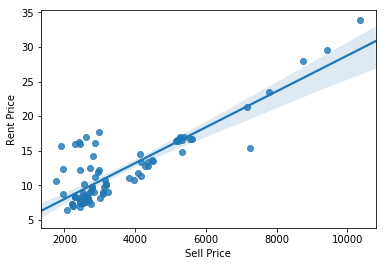

In [22]:
sns.regplot(x="Sell Price", y="Rent Price", data = neighborhood_df)

## First qualitative analysis
Just to check what I have collected untill now, I made some aggregation:

In [23]:
def modeAgg(x):
    return scipy.stats.mode(x)[0]

venues_grouped = venues[["Neighborhood", "Venue Category", "Macro Category"]].groupby(by = "Neighborhood").agg({
    'Macro Category': ['count', 'nunique', modeAgg],
    'Venue Category': [modeAgg, 'nunique']
})
venues_grouped.head()

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Macro Category                          Venue Category        
                      count nunique     modeAgg             modeAgg nunique
Neighborhood                                                               
ADRIANO                  22       5        Food         Coffee Shop      13
AFFORI                   26       6  Spare time    Pizza Restaurant      17
BAGGIO                   15       4  Restaurant         Coffee Shop       9
BANDE NERE               62       6  Restaurant  Italian Restaurant      23
BARONA                   12       5       Sport                 Gym      11

## One Hod encoding and general correlation
General one hot encoding for features

In [24]:
def one_hot_encoding(df, category, index = 'Neighborhood'):
    r = pd.get_dummies(df[[category]], prefix="", prefix_sep="")
    r[index] = df[index]
    r = r.groupby(index).mean().reset_index()
    return r

venues_onehot_micro = one_hot_encoding(venues, 'Venue Category')
venues_onehot_micro.head()

Neighborhood  African Restaurant  American Restaurant  Art Gallery  \
0      ADRIANO                0.00                 0.00         0.00   
1       AFFORI                0.00                 0.04         0.00   
2       BAGGIO                0.00                 0.00         0.00   
3   BANDE NERE                0.00                 0.00         0.02   
4       BARONA                0.00                 0.00         0.00   

   Asian Restaurant  Automotive Shop  Bookstore  Building  Chinese Restaurant  \
0              0.00             0.00       0.00      0.00                0.00   
1              0.00             0.00       0.00      0.00                0.00   
2              0.00             0.00       0.00      0.00                0.00   
3              0.00             0.00       0.00      0.00                0.02   
4              0.08             0.00       0.00      0.08                0.00   

   Clothing Store  ...  South American Restaurant  Spanish Restaurant  \
0            0.00  ...                       0.00                0.00   
1            0.00  ...                       0.00                0.00   
2            0.00  ...                       0.00                0.00   
3            0.00  ...                       0.00                0.00   
4            0.00  ...                       0.00                0.00   

   Stadium  Street Art  Strip Club  Supermarket  Theater  Transport  \
0     0.00        0.00        0.00         0.05     0.00       0.00   
1     0.00        0.00        0.00         0.12     0.00       0.04   
2     0.00        0.00        0.00         0.13     0.00       0.07   
3     0.02        0.00        0.00         0.05     0.02       0.02   
4     0.08        0.00        0.00         0.00     0.08       0.00   

   Turkish Restaurant  Wine Bar  
0                0.00      0.05  
1                0.04      0.08  
2                0.00      0.00  
3                0.00      0.02  
4                0.00      0.00  

[5 rows x 61 columns]

## Top hitters
I'm going to group all the data we saw before into groups of top hitters

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

def top_hitters(original_data, th = 5):
    TOP_HITTERS_COUNT = th
    if original_data.shape[1] <= th :
        TOP_HITTERS_COUNT = original_data.shape[1] - 1
    COLUMNS = ['Neighborhood']
    for ind in np.arange(TOP_HITTERS_COUNT):
        COLUMNS.append('{}^ most common venue'.format(ind+1))
    df = pd.DataFrame(columns=COLUMNS)
    df['Neighborhood'] = original_data['Neighborhood']    
    for ind in np.arange(original_data.shape[0]):
        df.iloc[ind, 1:] = return_most_common_venues(original_data.iloc[ind, :], TOP_HITTERS_COUNT)
    return df

neighborhoods_venues_micro_sorted = top_hitters(venues_onehot_micro, th = 10)
neighborhoods_venues_micro_sorted.head()

Neighborhood 1^ most common venue 2^ most common venue 3^ most common venue  \
0      ADRIANO          Coffee Shop   Italian Restaurant     Hotel and hostel   
1       AFFORI     Pizza Restaurant          Supermarket             Wine Bar   
2       BAGGIO     Pizza Restaurant          Coffee Shop          Supermarket   
3   BANDE NERE   Italian Restaurant     Pizza Restaurant     Hotel and hostel   
4       BARONA                  Gym              Stadium                 Park   

  4^ most common venue 5^ most common venue 6^ most common venue  \
0     Pizza Restaurant             Wine Bar                Goods   
1          Coffee Shop     Hotel and hostel                 Park   
2                 Park   Italian Restaurant  Japanese Restaurant   
3          Coffee Shop  Japanese Restaurant             Landmark   
4                Court          Coffee Shop  Japanese Restaurant   

  7^ most common venue 8^ most common venue 9^ most common venue  \
0    Healthy food Shop            Ice Cream             Landmark   
1                Hobby                Court                 Pool   
2            Transport             Landmark         Italian food   
3            Ice Cream          Supermarket    Healthy food Shop   
4   Italian Restaurant             Building     Asian Restaurant   

  10^ most common venue  
0            Fornitures  
1       Cultural Center  
2            Fornitures  
3         Grocery Store  
4               Theater

In [26]:
def random_state_finder(one_hot_df, top_hitters_df, clusters):
    clustering = one_hot_df.drop('Neighborhood', 1)
    rs = []
    for i in range(1, 10):
        kmeans = KMeans(n_clusters=clusters, random_state=i).fit(clustering)
        y = None
        y = np.bincount(kmeans.labels_)
        rs.append({'random_state' : i, 'deviation' : np.std(y), 'kmean' : kmeans})
    dev = min(f['deviation'] for f in rs)
    random_state = min(f['random_state'] for f in filter(lambda x: True if x['deviation'] == dev else False, rs))
    one_hot_df['Cluster'] = rs[random_state-1]['kmean'].labels_    
    top_hitters_df['Cluster'] = rs[random_state-1]['kmean'].labels_
    '''kmeans = KMeans(n_clusters=clusters, random_state=0).fit(clustering)
    one_hot_df['Cluster'] = kmeans.labels_    
    top_hitters_df['Cluster'] = kmeans.labels_'''
    
def map_builder(prop, original_df, column = 'name'):
    kclusters = 10
    bins = len(original_df[prop].unique()) - 1
    n = folium.Map(location=PLACE, zoom_start=12, tiles='Stamen Toner')
    n.choropleth(geo_data=NEIGHBORHOOD_FILE, data=original_df,  
             columns=[column, prop],
             key_on='feature.properties.NIL',
             fill_color='Accent',
             fill_opacity=0.8,
             line_opacity=0.9,
             highlight = True,
             bins = bins,
             legend_name=prop)
    folium.LayerControl().add_to(n)
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    return n
random_state_finder(venues_onehot_micro, neighborhoods_venues_micro_sorted, 6)
m = map_builder('Cluster', venues_onehot_micro, column = "Neighborhood")
m

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [27]:
def mode(x):
    return x.mode()[0]
def freq(x):
    return '{0:.2f}%'.format(100 * x.value_counts()[0] / x.count())

neighborhoods_venues_micro_sorted.groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   })

Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                 20     Pizza Restaurant   40.00%          Supermarket   
1                 28   Italian Restaurant   89.29%     Hotel and hostel   
2                 31   Italian Restaurant   45.16%   Italian Restaurant   
3                  1            Gift Shop  100.00%       Clothing Store   
4                  4                  Gym   75.00%              Stadium   
5                  2          Coffee Shop  100.00%     Hotel and hostel   

                 3^ most common venue          4^ most common venue           \
            freq                 mode     freq                 mode     freq   
Cluster                                                                        
0         15.00%     Hotel and hostel   15.00%          Coffee Shop   15.00%   
1         14.29%          Coffee Shop   17.86%          Coffee Shop   14.29%   
2         41.94%          Coffee Shop   16.13%     Hotel and hostel   12.90%   
3        100.00%             Wine Bar  100.00%  European Restaurant  100.00%   
4         50.00%             Building   25.00%                Court   50.00%   
5        100.00%   Italian Restaurant   50.00%             Wine Bar  100.00%   

            5^ most common venue           
                            mode     freq  
Cluster                                    
0                    Coffee Shop   20.00%  
1            Japanese Restaurant   14.29%  
2                    Supermarket   12.90%  
3        Health & Beauty Service  100.00%  
4                    Coffee Shop   25.00%  
5            European Restaurant  100.00%

We can now aggregate with this tecnique every group:

In [28]:
DATASET = {}
for category in venues["Macro Category"].unique():
    try:
        venues_for = venues[venues["Macro Category"] == category]
        one_hot = one_hot_encoding(venues_for, 'Venue Category')
        DATASET[category] = {}
        DATASET[category]['one_hot'] = one_hot
        DATASET[category]['top_hitters'] = top_hitters(one_hot)
    except:
        print(category)
        
DATASET['Restaurant']['top_hitters'].head()

Neighborhood 1^ most common venue 2^ most common venue 3^ most common venue  \
0      ADRIANO   Italian Restaurant     Pizza Restaurant   Turkish Restaurant   
1       AFFORI     Pizza Restaurant   Turkish Restaurant  Japanese Restaurant   
2       BAGGIO     Pizza Restaurant  Japanese Restaurant   Italian Restaurant   
3   BANDE NERE   Italian Restaurant     Pizza Restaurant  Japanese Restaurant   
4       BARONA  Japanese Restaurant   Italian Restaurant     Asian Restaurant   

  4^ most common venue       5^ most common venue  
0   Spanish Restaurant  South American Restaurant  
1   Italian Restaurant        American Restaurant  
2   Turkish Restaurant         Spanish Restaurant  
3   Chinese Restaurant         Turkish Restaurant  
4   Turkish Restaurant         Spanish Restaurant

Clustering without saying nothing about the category seem too less to me. Let's cluster by venue category.

## `Micro` venues clustering

In [29]:
def elbow_plot(df, label = 'k_values'):
    clustering = df.drop('Neighborhood', 1)
    keys = []
    interias = []
    for k in range (1, 10):
        kmeans_model = KMeans(n_clusters=k, random_state=0).fit(clustering)
        interia = kmeans_model.inertia_
        keys.append(k)
        interias.append(interia)
    s = pd.DataFrame({label: keys, 'inertia': interias})
    s.plot.line(x = label, y = "inertia")

## Elbow method for every category
Let's do that!

How many categories do I have?

In [30]:
DATASET.keys()

dict_keys(['Culture', 'Shopping', 'Restaurant', 'Health and Care', 'Sport', 'Food', 'Spare time'])

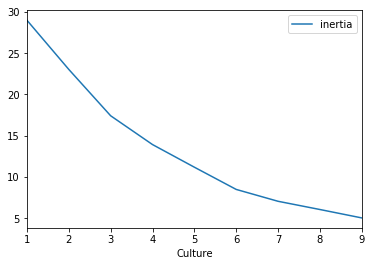

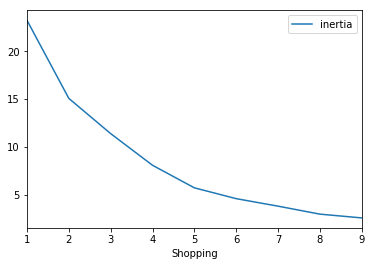

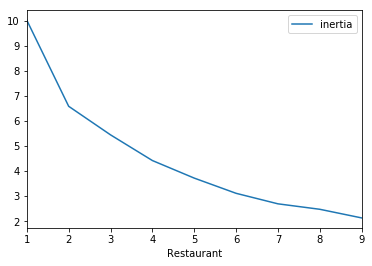

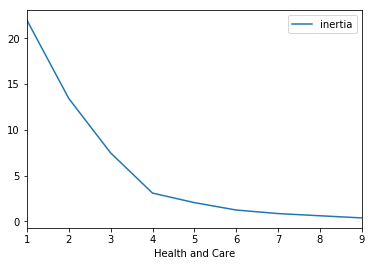

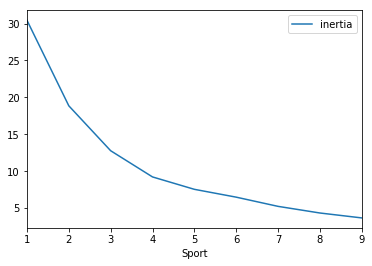

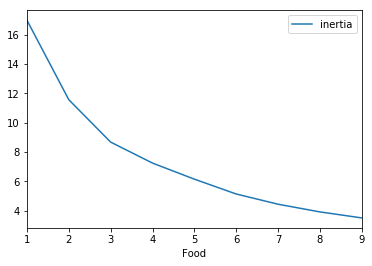

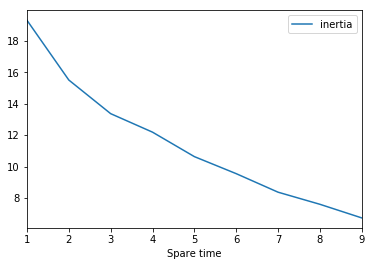

In [31]:
for category in DATASET.keys():
    elbow_plot(DATASET[category]['one_hot'], category)

In [32]:
ELBOW_ARRAY = [3, 5, 4, 4, 4, 4, 3]

In [33]:
#ELBOW_ARRAY = [3, 5, 7, 4,3, 5, 3, 3, 3]
i = 0
for category in DATASET.keys():
    DATASET[category]['elbow'] = ELBOW_ARRAY[i]
    i = i+1

for category in DATASET.keys():
    random_state_finder(DATASET[category]['one_hot'], DATASET[category]['top_hitters'], DATASET[category]['elbow'])
    print(category)
    neighborhood_df['{} Cluster'.format(category)] = neighborhood_df.name.map(lambda x: finder(x, DATASET[category]['one_hot'], 'Neighborhood', 'Cluster'))

Culture
Shopping
Restaurant
Health and Care
Sport
Food
Spare time


In [34]:
category = list(DATASET.keys())[0]
print(category)
reconversion = {}
reconversion[category] = ["Prevalence of Museums and Theater",
                                    "Street Art and Movie Theater",
                                    "Interesting buildings, Street Art and Museums"]
DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   })


Culture


Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                 41               Museum   24.39%              Theater   
1                 18              Theater  100.00%           Street Art   
2                  6             Building  100.00%              Theater   

                 3^ most common venue          4^ most common venue           \
            freq                 mode     freq                 mode     freq   
Cluster                                                                        
0         43.90%           Street Art   34.15%               Museum   36.59%   
1         33.33%           Street Art   50.00%               Museum   44.44%   
2        100.00%           Street Art  100.00%               Museum  100.00%   

        5^ most common venue           
                        mode     freq  
Cluster                                
0              Movie Theater   34.15%  
1              Movie Theater   44.44%  
2              Movie Theater  100.00%

In [35]:
category = list(DATASET.keys())[1]
print(category)
reconversion[category] = ["Domestic neighborhoods",
                                    "Gift shops",
                                   "Supermarkets",
                                   "Almost luxury shops",
                                  "Clothing shops"]
DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   })


Shopping


Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                  7           Fornitures  100.00%          Supermarket   
1                 31          Supermarket   96.77%            Gift Shop   
2                 15          Supermarket  100.00%       Hardware Store   
3                  4            Gift Shop  100.00%          Supermarket   
4                 15       Clothing Store   73.33%          Supermarket   

                 3^ most common venue          4^ most common venue           \
            freq                 mode     freq                 mode     freq   
Cluster                                                                        
0         71.43%       Hardware Store   57.14%            Gift Shop   57.14%   
1         32.26%       Hardware Store   48.39%            Gift Shop   38.71%   
2         80.00%            Gift Shop   80.00%           Fornitures   86.67%   
3        100.00%       Hardware Store  100.00%           Fornitures  100.00%   
4         33.33%          Supermarket   46.67%       Hardware Store   40.00%   

        5^ most common venue           
                        mode     freq  
Cluster                                
0             Clothing Store   57.14%  
1             Clothing Store   41.94%  
2             Clothing Store   86.67%  
3             Clothing Store  100.00%  
4                 Fornitures   40.00%

In [36]:
category = list(DATASET.keys())[2]
print(category)
reconversion[category] = ["Pizza and Turkish",
                                    "Italian and Asian",
                                   "South Americans",
                                   "Turkish and Spanish",
                                  "Italian and Japanese"]
DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   })


Restaurant


Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                 12     Pizza Restaurant   91.67%   Italian Restaurant   
1                 37   Italian Restaurant   91.89%     Pizza Restaurant   
2                  4   Italian Restaurant  100.00%   Turkish Restaurant   
3                 29   Italian Restaurant   65.52%     Pizza Restaurant   

                 3^ most common venue                4^ most common venue  \
            freq                 mode     freq                       mode   
Cluster                                                                     
0         33.33%   Turkish Restaurant   25.00%         Turkish Restaurant   
1         32.43%     Asian Restaurant   21.62%         Chinese Restaurant   
2        100.00%   Spanish Restaurant  100.00%  South American Restaurant   
3         65.52%  Japanese Restaurant   31.03%         Spanish Restaurant   

                       5^ most common venue           
            freq                       mode     freq  
Cluster                                               
0         33.33%  South American Restaurant   33.33%  
1         27.03%           Asian Restaurant   32.43%  
2        100.00%           Pizza Restaurant  100.00%  
3         31.03%         Turkish Restaurant   31.03%

In [37]:
category = list(DATASET.keys())[3]
print(category)
DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   })

Health and Care


Neighborhood     1^ most common venue          2^ most common venue  \
               count                     mode     freq                 mode   
Cluster                                                                       
0                 10           Cosmetics Shop   90.00%            Men store   
1                 10                 Massages  100.00%            Men store   
2                  7           Medical Center   85.71%            Men store   
3                  9  Health & Beauty Service   88.89%            Men store   

                 3^ most common venue              4^ most common venue  \
            freq                 mode     freq                     mode   
Cluster                                                                   
0         80.00%       Medical Center   80.00%                 Massages   
1        100.00%       Medical Center  100.00%  Health & Beauty Service   
2         57.14%             Massages   71.43%  Health & Beauty Service   
3         88.89%       Medical Center   66.67%                 Massages   

                     5^ most common venue           
            freq                     mode     freq  
Cluster                                             
0         80.00%  Health & Beauty Service  100.00%  
1        100.00%           Cosmetics Shop  100.00%  
2         71.43%           Cosmetics Shop  100.00%  
3         66.67%           Cosmetics Shop   77.78%

In [38]:
category = list(DATASET.keys())[4]
print(category)
reconversion[category] = ["Stadium and Pools",
                                    "Gyms",
                                   "Goods",
                                   "Courts"]
DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   })


Sport


Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                 24                  Gym  100.00%              Stadium   
1                 27                  Gym   37.04%                  Gym   
2                 10                Goods   50.00%                Goods   
3                 12                Court  100.00%              Stadium   

                3^ most common venue         4^ most common venue          \
           freq                 mode    freq                 mode    freq   
Cluster                                                                     
0        79.17%                 Pool  79.17%                Goods  91.67%   
1        33.33%                Court  29.63%                  Gym  25.93%   
2        50.00%              Stadium  60.00%                 Pool  70.00%   
3        83.33%                 Pool  83.33%                  Gym  83.33%   

        5^ most common venue          
                        mode    freq  
Cluster                               
0                      Field  91.67%  
1                      Goods  66.67%  
2                      Field  90.00%  
3                      Goods  91.67%

In [39]:
category = list(DATASET.keys())[5]
print(category)
reconversion[category] = ["Ice creams and Coffee shops",
                                    "Healthy food",
                                   "Italian food",
                                   "Coffee shops and groceries"]
DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   })


Food


Neighborhood 1^ most common venue          2^ most common venue  \
               count                 mode     freq                 mode   
Cluster                                                                   
0                 24            Ice Cream   33.33%          Coffee Shop   
1                  5                 Snak  100.00%         Italian food   
2                 19          Coffee Shop  100.00%                 Snak   
3                 33          Coffee Shop   81.82%                 Snak   

                3^ most common venue         4^ most common venue          \
           freq                 mode    freq                 mode    freq   
Cluster                                                                     
0        25.00%            Ice Cream  25.00%                 Snak  37.50%   
1        60.00%            Ice Cream  60.00%    Healthy food Shop  60.00%   
2        52.63%         Italian food  47.37%            Ice Cream  52.63%   
3        27.27%            Ice Cream  30.30%        Grocery Store  24.24%   

        5^ most common venue          
                        mode    freq  
Cluster                               
0              Grocery Store  29.17%  
1              Grocery Store  60.00%  
2          Healthy food Shop  57.89%  
3                  Ice Cream  24.24%

In [40]:
category = list(DATASET.keys())[6]
print(category)
reconversion[category] = ["Tourist accomodations and nighlife",
                                    "Parks, clubs and strip club",
                                   "Nightlife"]
DATASET[category]['top_hitters'].groupby(by = "Cluster").agg({'Neighborhood': 'count', 
                                                                   '1^ most common venue': [mode, freq],
                                                                    '2^ most common venue': [mode, freq],
                                                                    '3^ most common venue': [mode, freq],
                                                                    '4^ most common venue': [mode, freq],
                                                                    '5^ most common venue': [mode, freq]
                                                                   })


Spare time


Neighborhood 1^ most common venue         2^ most common venue  \
               count                 mode    freq                 mode   
Cluster                                                                  
0                 31     Hotel and hostel  58.06%             Wine Bar   
1                 19            Transport  63.16%                 Park   
2                 31             Wine Bar  29.03%            Nightlife   

                3^ most common venue         4^ most common venue          \
           freq                 mode    freq                 mode    freq   
Cluster                                                                     
0        32.26%             Wine Bar  35.48%            Transport  19.35%   
1        47.37%             Landmark  21.05%             Wine Bar  31.58%   
2        29.03%     Hotel and hostel  22.58%             Wine Bar  16.13%   

        5^ most common venue          
                        mode    freq  
Cluster                               
0                  Nightlife  19.35%  
1                 Strip Club  31.58%  
2                       Park  16.13%

In [41]:
for category in DATASET.keys():
    m = map_builder('{} Cluster'.format(category), neighborhood_df)
    m.save(outfile = 'milan_data/map-{}.html'.format(category))
    print('Map of {}'.format(category))
    display(m)

Map of Culture


C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Map of Shopping


Map of Restaurant


Map of Health and Care


Map of Sport


Map of Food


Map of Spare time


### Density based plots
We provide some density based prots for primary categories

In [42]:
venues_dummies = pd.get_dummies(venues[["Macro Category"]], prefix="Is ", prefix_sep="")
venues_dummies["Neighborhood"] = venues["Neighborhood"]
venues_dummies = venues_dummies.groupby("Neighborhood").sum().reset_index()
venues_nighlife = venues[venues["Venue Category"] == "Nightlife"].groupby("Neighborhood")[["Venue"]].count().reset_index()
def venuesFinder(x, venues_nighlife):
    try:
        return venues_nighlife[venues_nighlife['Neighborhood'] == x]['Venue'].values[0]
    except:
        return 0
venues_dummies["Is Nightlife"] = venues_dummies["Neighborhood"].map(lambda x: venuesFinder(x, venues_nighlife))

for column in venues_dummies.columns:
    if column != "Neighborhood":
        venues_dummies[column] = venues_dummies[column].astype('int64', copy = False)
        
m = folium.Map(location=PLACE, zoom_start=12, tiles='stamenterrain')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=venues_dummies,  
             columns=['Neighborhood', 'Is Nightlife'],
             key_on='feature.properties.NIL',
             fill_color='RdYlGn',
             fill_opacity=0.8,
             line_opacity=0.1,
             highlight = True,
             legend_name='Neighborhood surface')
m

In [43]:
venues_dummies.head()

Neighborhood  Is Culture  Is Food  Is Health and Care  Is Restaurant  \
0      ADRIANO           0        8                   0              6   
1       AFFORI           1        3                   0              7   
2       BAGGIO           0        4                   0              5   
3   BANDE NERE           2       16                   0             24   
4       BARONA           2        2                   0              3   

   Is Shopping  Is Spare time  Is Sport  Is Nightlife  
0            3              4         1             0  
1            3             10         2             0  
2            2              4         0             0  
3            5             12         3             0  
4            0              1         4             0

In [44]:
m = folium.Map(location=PLACE, zoom_start=12, tiles='stamenterrain')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=venues_dummies,  
             columns=['Neighborhood', 'Is Restaurant'],
             key_on='feature.properties.NIL',
             fill_color='RdYlGn',
             fill_opacity=0.8,
             line_opacity=0.1,
             highlight = True,
             legend_name='Restaurants density in Milan')
m

In [45]:
m = folium.Map(location=PLACE, zoom_start=12, tiles='stamenterrain')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=venues_dummies,  
             columns=['Neighborhood', 'Is Shopping'],
             key_on='feature.properties.NIL',
             fill_color='RdYlGn',
             fill_opacity=0.8,
             line_opacity=0.1,
             highlight = True,
             legend_name='Shopping places in Milan')
m

In [46]:
m = folium.Map(location=PLACE, zoom_start=12, tiles='stamenterrain')
m.choropleth(geo_data=NEIGHBORHOOD_FILE, data=venues_dummies,  
             columns=['Neighborhood', 'Is Food'],
             key_on='feature.properties.NIL',
             fill_color='RdYlGn',
             fill_opacity=0.8,
             line_opacity=0.1,
             highlight = True,
             legend_name='Generic food stores in Milan')
m

### Preparing for decision tree and data regression

In [47]:
binsName = ["Low", "Medium", "High"]
df = venues_dummies[["Neighborhood"]]
for column in venues_dummies.columns:
    if column != "Neighborhood":
        venues_dummies[column] = venues_dummies[column].astype('int64', copy = False)
        columnBin = np.linspace(min(venues_dummies[column]), max(venues_dummies[column]), len(binsName)+1)
        df['{} bin'.format(column)] = pd.cut(venues_dummies[column], columnBin, labels=binsName, include_lowest=True)
df.head()

C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Neighborhood Is Culture bin Is Food bin Is Health and Care bin  \
0      ADRIANO            Low         Low                    Low   
1       AFFORI            Low         Low                    Low   
2       BAGGIO            Low         Low                    Low   
3   BANDE NERE            Low      Medium                    Low   
4       BARONA            Low         Low                    Low   

  Is Restaurant bin Is Shopping bin Is Spare time bin Is Sport bin  \
0               Low             Low               Low          Low   
1               Low             Low               Low          Low   
2               Low             Low               Low          Low   
3            Medium             Low            Medium          Low   
4               Low             Low               Low       Medium   

  Is Nightlife bin  
0              Low  
1              Low  
2              Low  
3              Low  
4              Low

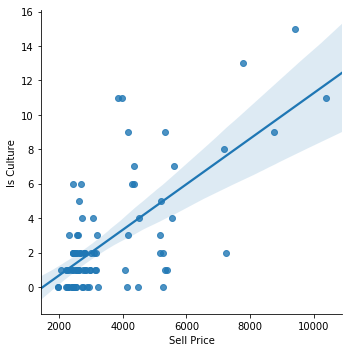

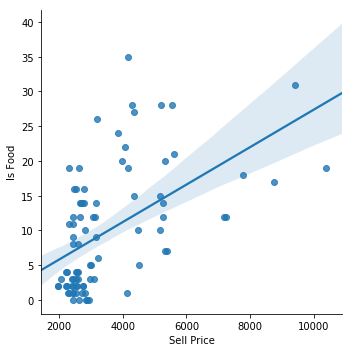

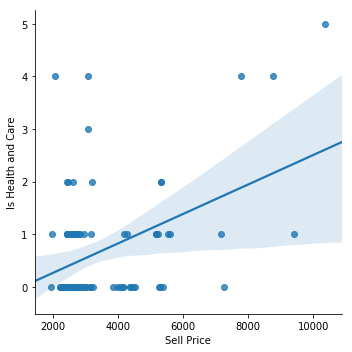

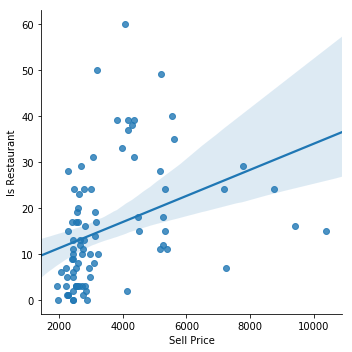

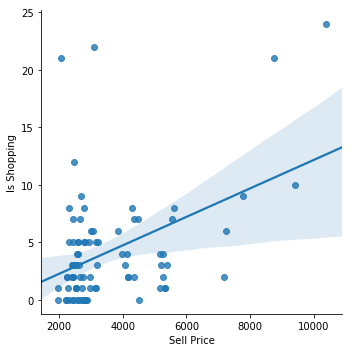

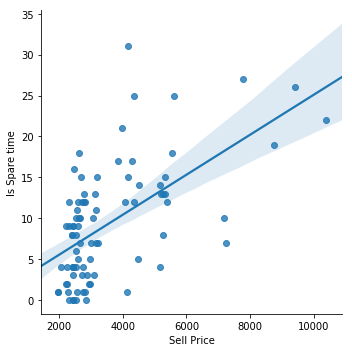

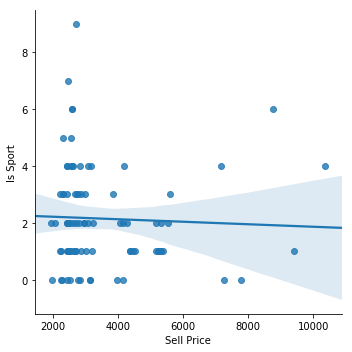

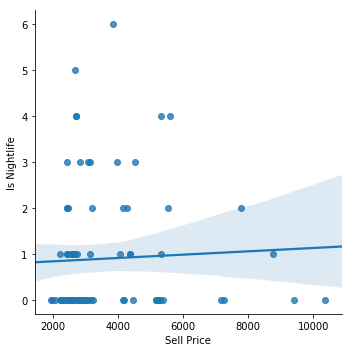

In [48]:
venues_dummies['Sell Price'] = venues_dummies["Neighborhood"].map(lambda x: finder(x, sellpricedf, 'Neighborhood', 'mean'))
venues_dummies['Rent Price'] = venues_dummies["Neighborhood"].map(lambda x: finder(x, rentpricedf, 'Neighborhood', 'mean'))
for column in venues_dummies:
    if "Is " in column:
        sns.lmplot(x="Sell Price", y=column, data = venues_dummies)

In [49]:
venues_dummies["District"] = venues_dummies["Neighborhood"].map(lambda x: finder(x, neighborhood_df, "name", "District"))
venues_dummies.head()

Neighborhood  Is Culture  Is Food  Is Health and Care  Is Restaurant  \
0      ADRIANO           0        8                   0              6   
1       AFFORI           1        3                   0              7   
2       BAGGIO           0        4                   0              5   
3   BANDE NERE           2       16                   0             24   
4       BARONA           2        2                   0              3   

   Is Shopping  Is Spare time  Is Sport  Is Nightlife  Sell Price  Rent Price  \
0            3              4         1             0    2,450.00        7.75   
1            3             10         2             0    2,532.00        7.38   
2            2              4         0             0    2,257.00        7.00   
3            5             12         3             0    2,782.67        9.71   
4            0              1         4             0    2,563.00       10.25   

       District  
0  2^ Municipio  
1  9^ Municipio  
2  7^ Municipio  
3  6^ Municipio  
4  6^ Municipio

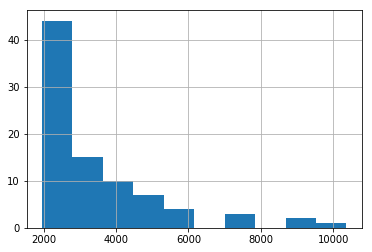

In [50]:
binsName = ["Very low", "Low", "Medium", "High", "Very high"]
columnBin = np.linspace(min(venues_dummies["Sell Price"]), max(venues_dummies["Sell Price"]), len(binsName)+1)
df['Sell Price'] = pd.cut(venues_dummies["Sell Price"], columnBin, labels=binsName, include_lowest=True)

binsName = ["Low", "Medium", "High"]
df["Buildings Sites"] = df["Neighborhood"].map(lambda x: finder(x, neighborhood_df, "name", "Building sites"))
columnBin = np.linspace(min(df["Buildings Sites"]), max(df["Buildings Sites"]), len(binsName)+1)
df["Buildings Sites"] = pd.cut(df["Buildings Sites"], columnBin, labels=binsName, include_lowest=True)

venues_dummies['Sell Price'].hist()

In [51]:
neighborhood_df.head()

name   lat  lng       AreaMQ  Radius  BusStops  BusStops per KM2  \
0        SACCO 45.46 9.15   708,465.80    0.47        31              0.00   
1     COMASINA 45.53 9.16   926,734.56    0.54        59              0.00   
2   STEPHENSON 45.51 9.11   560,097.89    0.42         1              0.00   
3         QT 8 45.49 9.14 1,024,437.42    0.57        19              0.00   
4  ORTOMERCATO 45.47 9.18 1,402,519.65    0.67        91              0.00   

   BusStops Normalized  Building sites      District  Sell Price  Rent Price  \
0                 0.63              18  7^ Municipio    5,164.00       16.38   
1                 0.92               6  9^ Municipio    2,532.00        7.38   
2                 0.03               2  8^ Municipio    1,972.50        8.75   
3                 0.27               8  8^ Municipio    2,711.50        9.07   
4                 0.94              63  4^ Municipio    9,409.00       29.57   

   Culture Cluster  Shopping Cluster  Restaurant Cluster  \
0             1.00              1.00                3.00   
1              nan              2.00                0.00   
2              nan               nan                 nan   
3              nan               nan                2.00   
4             0.00              0.00                3.00   

   Health and Care Cluster  Sport Cluster  Food Cluster  Spare time Cluster  
0                     3.00           2.00          0.00                2.00  
1                      nan            nan          2.00                1.00  
2                     1.00            nan          2.00                0.00  
3                     2.00           3.00          1.00                1.00  
4                     0.00           2.00          3.00                0.00

In [52]:
def kfinder(x, column, neighborhood_df, reconversion, prop = 'Neighborhood'):
    clsName = '{} Cluster'.format(column)
    val = neighborhood_df[neighborhood_df.name == x[prop]][clsName].values[0]
    if math.isnan(val):
        return "Other"
    else:
        return reconversion[column][int(val)]
    
for column in reconversion.keys():
    df[column] = df.apply(lambda x: kfinder(x, column, neighborhood_df, reconversion), axis=1)
    neighborhood_df[column + ' Cluster'] = neighborhood_df.apply(lambda x: kfinder(x, column, neighborhood_df, reconversion, prop = 'name'), axis=1)  

Let's start with decision tree:

In [53]:
reconversion

{'Culture': ['Prevalence of Museums and Theater',
  'Street Art and Movie Theater',
  'Interesting buildings, Street Art and Museums'],
 'Shopping': ['Domestic neighborhoods',
  'Gift shops',
  'Supermarkets',
  'Almost luxury shops',
  'Clothing shops'],
 'Restaurant': ['Pizza and Turkish',
  'Italian and Asian',
  'South Americans',
  'Turkish and Spanish',
  'Italian and Japanese'],
 'Sport': ['Stadium and Pools', 'Gyms', 'Goods', 'Courts'],
 'Food': ['Ice creams and Coffee shops',
  'Healthy food',
  'Italian food',
  'Coffee shops and groceries'],
 'Spare time': ['Tourist accomodations and nighlife',
  'Parks, clubs and strip club',
  'Nightlife']}

In [54]:
df.head()

Neighborhood Is Culture bin Is Food bin Is Health and Care bin  \
0      ADRIANO            Low         Low                    Low   
1       AFFORI            Low         Low                    Low   
2       BAGGIO            Low         Low                    Low   
3   BANDE NERE            Low      Medium                    Low   
4       BARONA            Low         Low                    Low   

  Is Restaurant bin Is Shopping bin Is Spare time bin Is Sport bin  \
0               Low             Low               Low          Low   
1               Low             Low               Low          Low   
2               Low             Low               Low          Low   
3            Medium             Low            Medium          Low   
4               Low             Low               Low       Medium   

  Is Nightlife bin Sell Price Buildings Sites  \
0              Low   Very low             Low   
1              Low   Very low          Medium   
2              Low   Very low             Low   
3              Low   Very low             Low   
4              Low   Very low             Low   

                             Culture      Shopping           Restaurant  \
0                              Other    Gift shops  Turkish and Spanish   
1  Prevalence of Museums and Theater  Supermarkets    Pizza and Turkish   
2                              Other  Supermarkets    Pizza and Turkish   
3       Street Art and Movie Theater    Gift shops  Turkish and Spanish   
4       Street Art and Movie Theater         Other    Italian and Asian   

   Sport                         Food                          Spare time  
0  Goods                 Italian food  Tourist accomodations and nighlife  
1   Gyms                 Italian food                           Nightlife  
2  Other                 Italian food         Parks, clubs and strip club  
3  Goods  Ice creams and Coffee shops  Tourist accomodations and nighlife  
4   Gyms   Coffee shops and groceries         Parks, clubs and strip club

### Diciding the district
We will realize a decision tree for a choosing the district basing our choice on questions

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import preprocessing
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
%matplotlib inline 

X = df.values[:, 1:]
Y = venues_dummies.values[:, -1]

bins_standard = ["Low", "Medium", "High"]
bins_expanded = ["Very low", "Low", "Medium", "High", "Very high"]
le = preprocessing.LabelEncoder()
le.fit(bins_standard)
X[:,0] = le.transform(X[:,0]) 
X[:,1] = le.transform(X[:,1]) 
X[:,2] = le.transform(X[:,2]) 
X[:,3] = le.transform(X[:,3]) 
X[:,4] = le.transform(X[:,4]) 
X[:,5] = le.transform(X[:,5]) 
X[:,6] = le.transform(X[:,6]) 
X[:,7] = le.transform(X[:,7])
X[:,9] = le.transform(X[:, 9])
le = preprocessing.LabelEncoder()
le.fit(bins_expanded)
X[:,8] = le.transform(X[:,8])
i = 10
for el in ["Culture", "Shopping", "Restaurant", "Sport", "Food", "Spare time"]:
    arr_expanded = list(reconversion[el])
    arr_expanded.append("Other")
    print(arr_expanded)
    le = preprocessing.LabelEncoder()
    le.fit(arr_expanded)
    X[:, i] = le.transform(X[:, i])
    i = i+1

['Prevalence of Museums and Theater', 'Street Art and Movie Theater', 'Interesting buildings, Street Art and Museums', 'Other']
['Domestic neighborhoods', 'Gift shops', 'Supermarkets', 'Almost luxury shops', 'Clothing shops', 'Other']
['Pizza and Turkish', 'Italian and Asian', 'South Americans', 'Turkish and Spanish', 'Italian and Japanese', 'Other']
['Stadium and Pools', 'Gyms', 'Goods', 'Courts', 'Other']
['Ice creams and Coffee shops', 'Healthy food', 'Italian food', 'Coffee shops and groceries', 'Other']
['Tourist accomodations and nighlife', 'Parks, clubs and strip club', 'Nightlife', 'Other']


C:\Users\cristiano.insola\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [56]:
dctree = DecisionTreeClassifier(criterion="gini", presort = True, )
dctree.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=None, splitter='best')

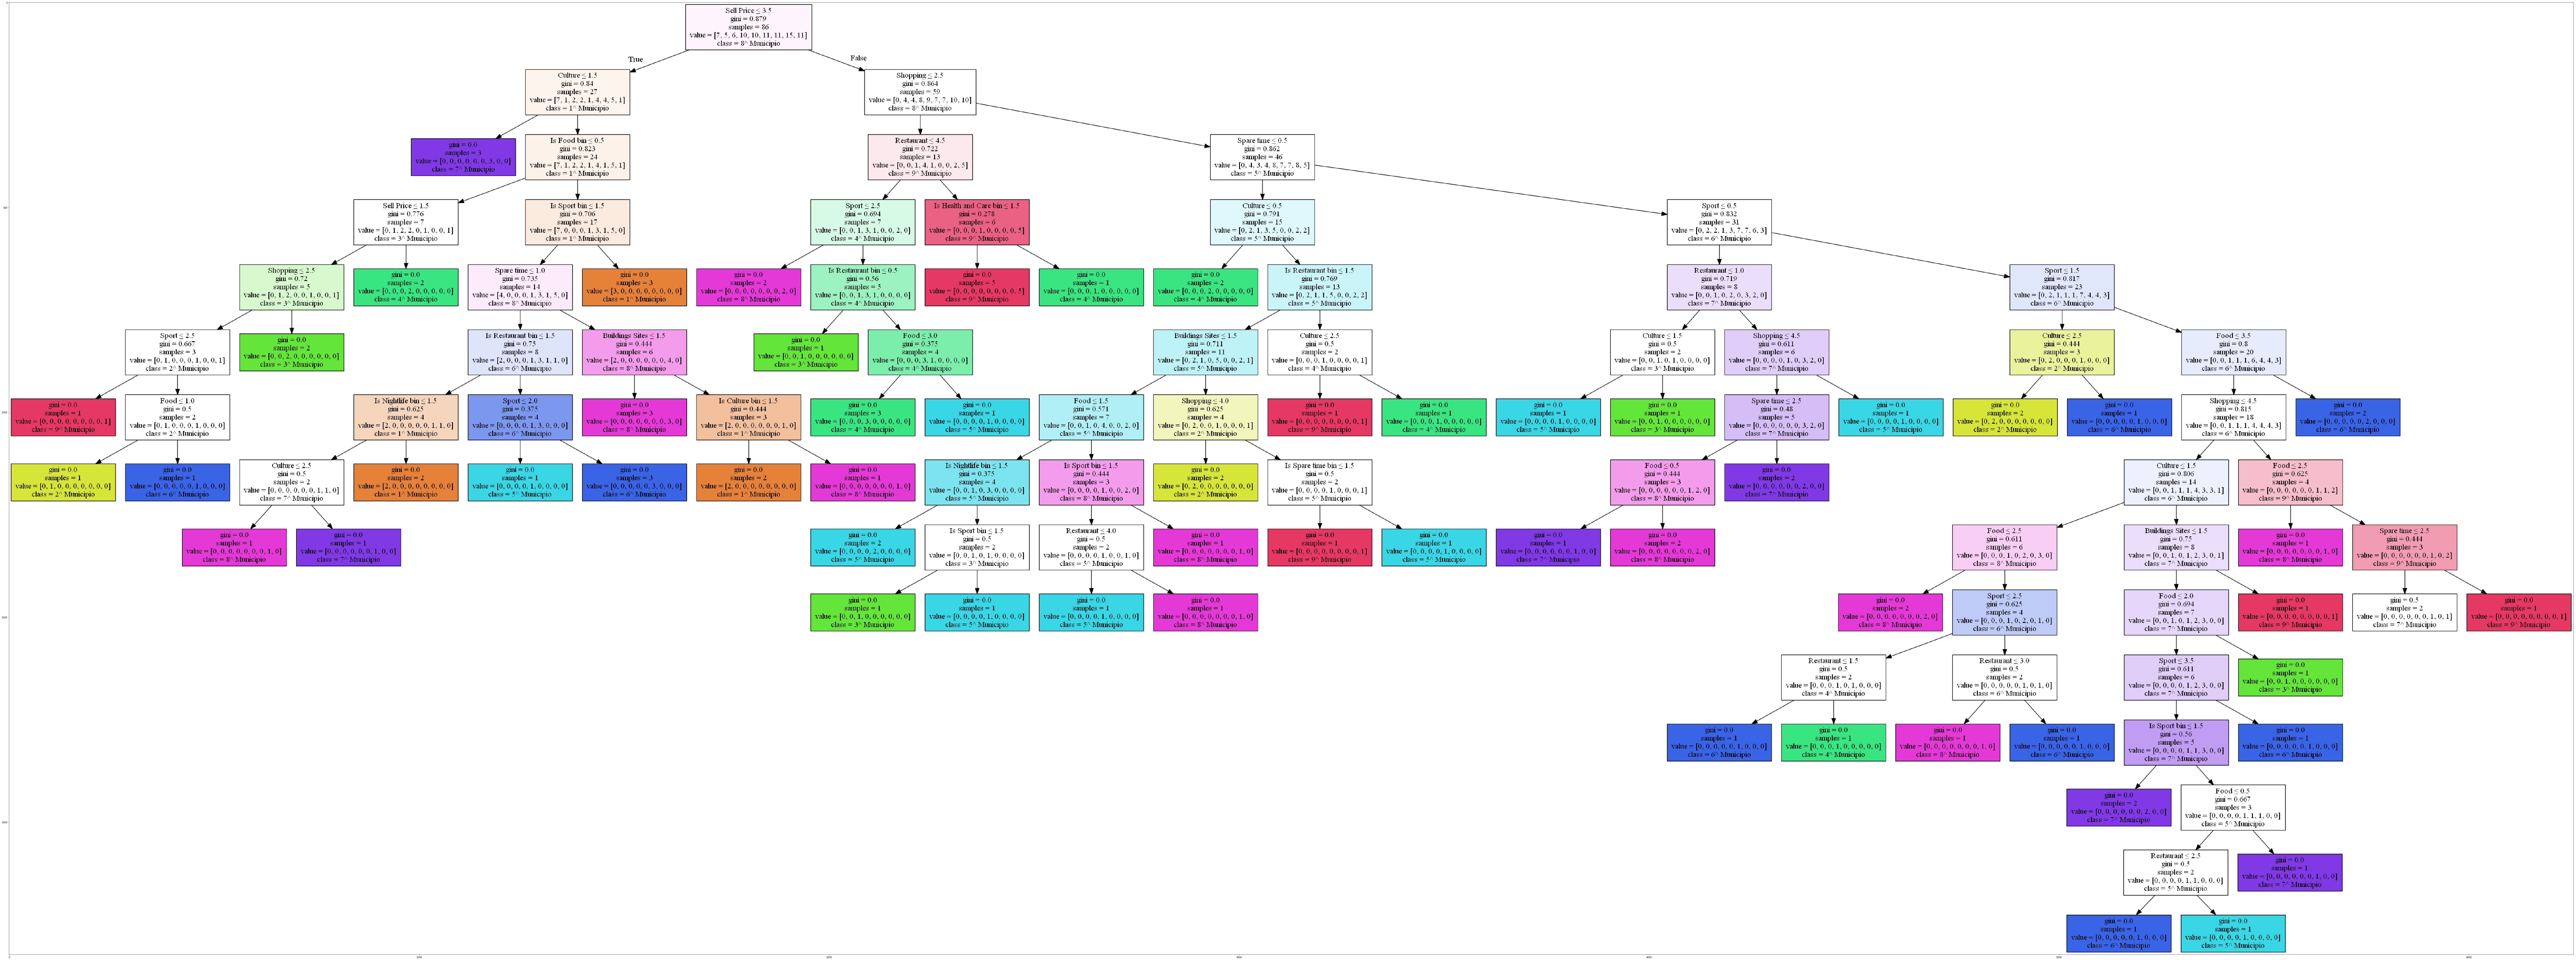

In [57]:
dot_data = StringIO()
filename = "tree.png"
featureNames = df.columns[1:]
out=tree.export_graphviz(dctree, feature_names=featureNames,
                         out_file=dot_data, 
                         class_names= dctree.classes_, 
                         filled=True,  
                         special_characters=True, 
                         rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(200, 400))
plt.imshow(img,interpolation='nearest')

In [58]:
neighborhood_df.to_csv('output/neightborhoodDataframe.csv')

In [59]:
neighborhood_df[["name", "AreaMQ", "BusStops", "Building sites", "District", "Sell Price", "Culture Cluster", "Shopping Cluster", "Restaurant Cluster", "Sport Cluster", "Food Cluster", "Spare time Cluster"]].head(10)

name       AreaMQ  BusStops  Building sites  \
0                   SACCO   708,465.80        31              18   
1                COMASINA   926,734.56        59               6   
2              STEPHENSON   560,097.89         1               2   
3                    QT 8 1,024,437.42        19               8   
4             ORTOMERCATO 1,402,519.65        91              63   
5      MAGGIORE - MUSOCCO 3,030,188.71        44              15   
6  PARCO LAMBRO - CIMIANO 4,971,969.50        37               5   
7             GALLARATESE 3,894,538.21        72              10   
8                 S. SIRO 3,435,307.37        10               0   
9                GHISOLFA 1,051,452.21        15              36   

       District  Sell Price                    Culture Cluster  \
0  7^ Municipio    5,164.00       Street Art and Movie Theater   
1  9^ Municipio    2,532.00                              Other   
2  8^ Municipio    1,972.50                              Other   
3  8^ Municipio    2,711.50                              Other   
4  4^ Municipio    9,409.00  Prevalence of Museums and Theater   
5  8^ Municipio    2,423.33       Street Art and Movie Theater   
6  3^ Municipio    2,600.00  Prevalence of Museums and Theater   
7  8^ Municipio    2,593.67  Prevalence of Museums and Theater   
8  7^ Municipio    4,142.33                              Other   
9  8^ Municipio    3,229.67                              Other   

         Shopping Cluster   Restaurant Cluster      Sport Cluster  \
0              Gift shops  Turkish and Spanish              Goods   
1            Supermarkets    Pizza and Turkish              Other   
2                   Other                Other              Other   
3                   Other      South Americans             Courts   
4  Domestic neighborhoods  Turkish and Spanish              Goods   
5            Supermarkets    Italian and Asian               Gyms   
6              Gift shops  Turkish and Spanish               Gyms   
7            Supermarkets    Italian and Asian               Gyms   
8              Gift shops    Italian and Asian               Gyms   
9              Gift shops  Turkish and Spanish  Stadium and Pools   

                  Food Cluster                  Spare time Cluster  
0  Ice creams and Coffee shops                           Nightlife  
1                 Italian food         Parks, clubs and strip club  
2                 Italian food  Tourist accomodations and nighlife  
3                 Healthy food         Parks, clubs and strip club  
4   Coffee shops and groceries  Tourist accomodations and nighlife  
5  Ice creams and Coffee shops  Tourist accomodations and nighlife  
6                 Italian food  Tourist accomodations and nighlife  
7                 Italian food                           Nightlife  
8                 Italian food         Parks, clubs and strip club  
9  Ice creams and Coffee shops  Tourist accomodations and nighlife